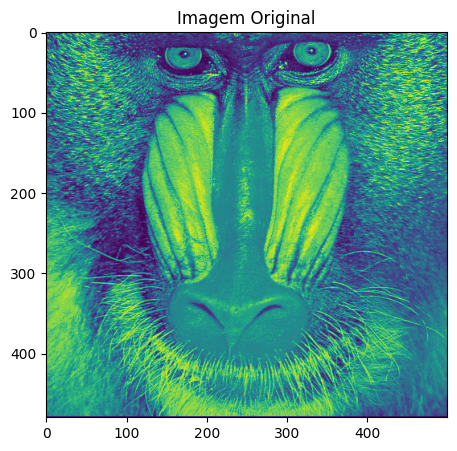

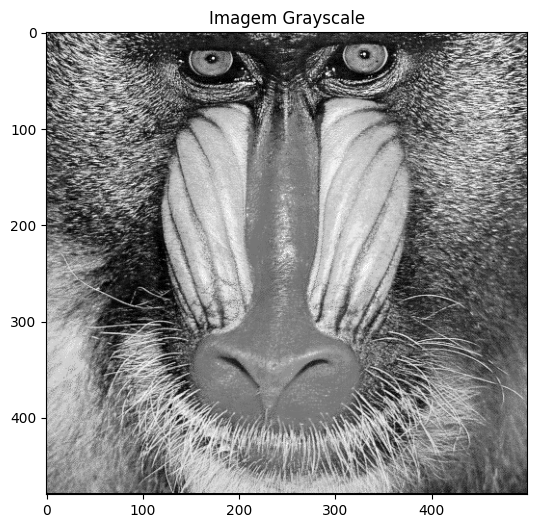

U shape: (480, 480), sigma length: 480, V shape: (480, 500)


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Carregar a imagem original
img = Image.open('./baboon.pgm')
plt.figure(figsize=(9,5))
plt.imshow(img)
plt.title("Imagem Original")
plt.show()

# Converter a imagem para grayscale (somente luminância)
imggray = img.convert('L')  # 'L' para imagem em escala de cinza
plt.figure(figsize=(9,6))
plt.imshow(imggray, cmap='gray')
plt.title("Imagem Grayscale")
plt.show()

# Converter a imagem para uma matriz numpy (apenas o canal de luminância)
original_img = np.array(imggray)

# Decomposição SVD
imgmat = np.array(imggray, dtype=float)
U, sigma, V = np.linalg.svd(imgmat, full_matrices=False)

# Exibir a forma dos componentes U, sigma e V
print(f"U shape: {U.shape}, sigma length: {len(sigma)}, V shape: {V.shape}")


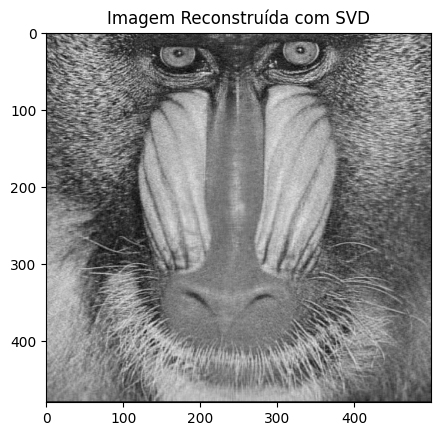

U_reduced shape: (480, 100), sigma_reduced length: 100, V_reduced shape: (100, 500)


In [56]:
# Número de termos a serem mantidos na reconstrução
term_number = 100  # Ajuste conforme necessário para a compressão e qualidade desejadas

# Manter apenas os primeiros 'term_number' termos em U, sigma e V
U_reduced = U[:, :term_number]
sigma_reduced = sigma[:term_number]
V_reduced = V[:term_number, :]

# Reconstruir a imagem com a dimensionalidade reduzida
reconstimg = np.dot(U_reduced, np.dot(np.diag(sigma_reduced), V_reduced))

# Exibir a imagem reconstruída
plt.imshow(reconstimg, cmap='gray')
plt.title("Imagem Reconstruída com SVD")
plt.show()

# Exibir a forma dos componentes reduzidos
print(f"U_reduced shape: {U_reduced.shape}, sigma_reduced length: {len(sigma_reduced)}, V_reduced shape: {V_reduced.shape}")


In [58]:
from collections import Counter
import heapq

# Função para aplicar a codificação Huffman
def huffman_encode(data):
    # Contagem da frequência dos elementos
    frequency = Counter(data)
    
    # Criar a fila de prioridades (min-heap)
    heap = [[weight, [symbol, ""]] for symbol, weight in frequency.items()]
    heapq.heapify(heap)
    
    # Construir a árvore de Huffman
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    
    # Obter a tabela de codificação Huffman
    huff_code = sorted(heap[0][1:], key=lambda p: (len(p[-1]), p))
    huff_dict = {symbol: code for symbol, code in huff_code}
    
    # Codificar os dados
    encoded_data = ''.join([huff_dict[symbol] for symbol in data])
    return huff_dict, encoded_data

# Codificar os coeficientes de sigma com Huffman
huff_dict, encoded_sigma = huffman_encode(sigma_reduced)

# Função para salvar os dados comprimidos em um arquivo binário
def save_compressed_file(encoded_data, filename="compressed_data.bin"):
    with open(filename, 'wb') as f:
        f.write(encoded_data.encode('utf-8'))

# Salvar os dados comprimidos
save_compressed_file(encoded_sigma, "compressed_data.bin")

# Exibir os dados comprimidos
print(f"Dados codificados e salvos em 'compressed_data.bin' com {len(encoded_sigma)} bits.")


Dados codificados e salvos em 'compressed_data.bin' com 672 bits.


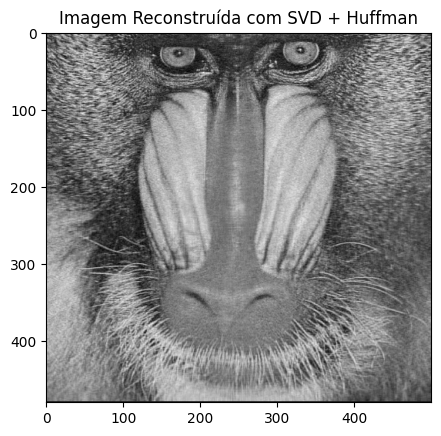

In [59]:
# Função para decodificar com Huffman
def huffman_decode(encoded_data, huff_dict, term_number):
    # Inverter o dicionário de Huffman
    reverse_huff_dict = {code: symbol for symbol, code in huff_dict.items()}
    
    # Decodificar os dados
    decoded_data = []
    current_code = ''
    for bit in encoded_data:
        current_code += bit
        if current_code in reverse_huff_dict:
            decoded_data.append(reverse_huff_dict[current_code])
            current_code = ''
    
    # Garantir que o número de elementos decodificados seja igual ao número de termos
    decoded_data = np.array(decoded_data[:term_number])
    
    # Se houver menos elementos, preencher com zeros
    if len(decoded_data) < term_number:
        decoded_data = np.pad(decoded_data, (0, term_number - len(decoded_data)), 'constant')
    
    return decoded_data

# Descodificar os coeficientes de sigma com Huffman
decoded_sigma = huffman_decode(encoded_sigma, huff_dict, term_number)

# Reconstruir a imagem com os coeficientes comprimidos
reconstimg_huffman = np.dot(U_reduced, np.dot(np.diag(decoded_sigma), V_reduced))

# Exibir a imagem reconstruída com Huffman
plt.imshow(reconstimg_huffman, cmap='gray')
plt.title("Imagem Reconstruída com SVD + Huffman")
plt.show()


In [ ]:
# Função para calcular o PSNR
def psnr(original_img, reconstructed_img):
    mse = np.mean((original_img - reconstructed_img) ** 2)
    max_pixel = 255.0
    return 10 * np.log10((max_pixel ** 2) / mse)

# Função para calcular a Taxa de Compressão
def compression_rate(original_img, compressed_data_filename):
    original_size = os.path.getsize('./baboon.pgm')  # Tamanho do arquivo original
    compressed_size = os.path.getsize(compressed_data_filename)  # Tamanho do arquivo comprimido
    return original_size / compressed_size

# Calcular a Taxa de Compressão e PSNR
rate = compression_rate(original_img, "compressed_data.bin")
psnr_value = psnr(original_img, reconstimg_huffman)

print(f"Taxa de Compressão: {rate:.2f}")
print(f"PSNR: {psnr_value:.2f} dB")

# Garantir que a Taxa de Compressão seja maior ou igual a 2 e PSNR maior ou igual a 32
if rate >= 2 and psnr_value >= 32:
    print("Os requisitos de Taxa de Compressão e PSNR foram atendidos!")
else:
    print("Ajuste os parâmetros para atender aos requisitos de Taxa de Compressão e PSNR.")


Taxa de Compressão: 16273.76
PSNR: 21.07 dB
Ajuste os parâmetros para atender aos requisitos de Taxa de Compressão e PSNR.
